In [1]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
#     -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/Users/cuitianyu/.keras/models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [5]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


In [6]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
# !wget --no-check-certificate \
#    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \
#    /tmp/cats_and_dogs_filtered.zip

In [8]:
import os
import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator

local_zip = './dataset/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./dataset')
zip_ref.close()

# Define our example directories and files
base_dir = './dataset/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=2,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/2
50/50 [==============================] - 21s 424ms/step - loss: 0.4494 - acc: 0.8780
 - 110s - loss: 0.5160 - acc: 0.7615 - val_loss: 0.4494 - val_acc: 0.8780
Epoch 2/2
50/50 [==============================] - 21s 414ms/step - loss: 0.5285 - acc: 0.8770
 - 107s - loss: 0.3760 - acc: 0.8325 - val_loss: 0.5285 - val_acc: 0.8770


In [10]:
from tensorflow.keras.optimizers import SGD

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
    if unfreeze:
        layer.trainable = True
    if layer.name == 'mixed6':
        unfreeze = True

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='binary_crossentropy',
              optimizer=SGD(
                  lr=0.00001, 
                  momentum=0.9),
              metrics=['acc'])

In [11]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/50
50/50 [==============================] - 21s 423ms/step - loss: 0.4072 - acc: 0.9100
 - 99s - loss: 0.4109 - acc: 0.7990 - val_loss: 0.4072 - val_acc: 0.9100
Epoch 2/50
50/50 [==============================] - 21s 410ms/step - loss: 0.3597 - acc: 0.9210
 - 97s - loss: 0.3229 - acc: 0.8615 - val_loss: 0.3597 - val_acc: 0.9210
Epoch 3/50
50/50 [==============================] - 21s 417ms/step - loss: 0.3369 - acc: 0.9240
 - 99s - loss: 0.2960 - acc: 0.8715 - val_loss: 0.3369 - val_acc: 0.9240
Epoch 4/50
50/50 [==============================] - 21s 417ms/step - loss: 0.3263 - acc: 0.9250
 - 98s - loss: 0.2935 - acc: 0.8630 - val_loss: 0.3263 - val_acc: 0.9250
Epoch 5/50
50/50 [==============================] - 21s 414ms/step - loss: 0.3251 - acc: 0.9260
 - 98s - loss: 0.2738 - acc: 0.8875 - val_loss: 0.3251 - val_acc: 0.9260
Epoch 6/50
50/50 [==============================] - 21s 421ms/step - loss: 0.3199 - acc: 0.9310
 - 99s - loss: 0.2791 - acc: 0.8795 - val_loss: 0.3199 - va

50/50 [==============================] - 21s 422ms/step - loss: 0.3428 - acc: 0.9240
 - 99s - loss: 0.2640 - acc: 0.8825 - val_loss: 0.3428 - val_acc: 0.9240
Epoch 50/50
50/50 [==============================] - 21s 422ms/step - loss: 0.3396 - acc: 0.9250
 - 99s - loss: 0.2528 - acc: 0.8905 - val_loss: 0.3396 - val_acc: 0.9250


Text(0.5, 1.0, 'Training and validation loss')

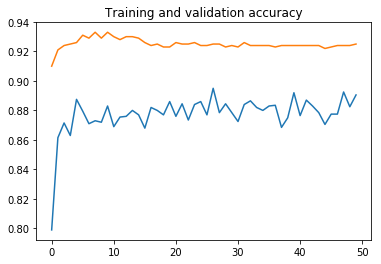

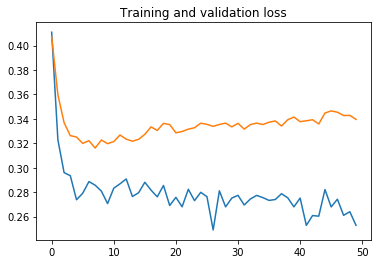

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')